In [1]:
# Import libraries
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from brain_dataset import BrainDataset
from brain_dataset import set_seed, dataset_info, print_model_architecture
from unet_architecture import UNet
from attention_gate import AttentionUNet

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Cpu or Gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


# Load files

In [3]:
BASE_PATH = 'input/lgg-mri-segmentation/kaggle_3m/'

mask_files = glob.glob(BASE_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
1,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
2,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
3,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
4,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
...,...,...,...
3924,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0
3925,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0
3926,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0
3927,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0


## Plotting the data

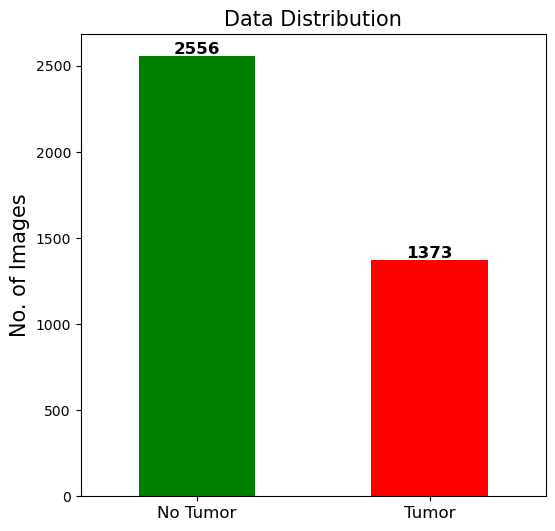

In [4]:

ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

## Split dataset

In [5]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


(-0.5, 1279.5, 255.5, -0.5)

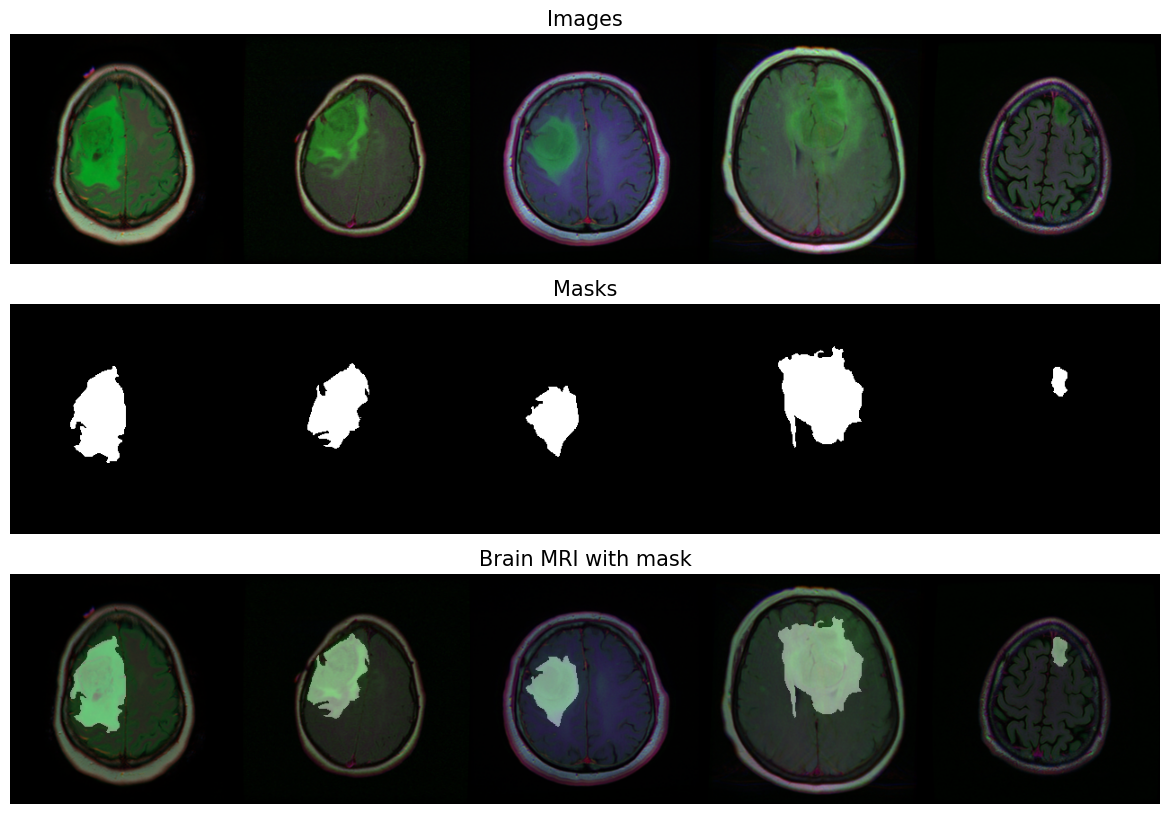

In [6]:
set_seed()

# Figure for images and masks for positive diagnosis
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

# Pytorch dataset format

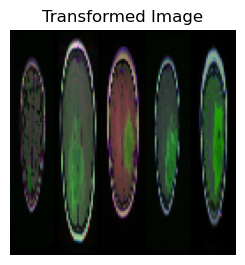

In [7]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

transformed_image = train_transform(image=images)['image']

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title('Transformed Image')
plt.axis('off')

plt.show()

In [8]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)


In [9]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



# Creating dataloaders

In [10]:
batch_size = 64

set_seed()
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,  
                      pin_memory=True)  

set_seed()
val_dl = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

test_dl = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

In [11]:
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


## Viewing samples from a batch

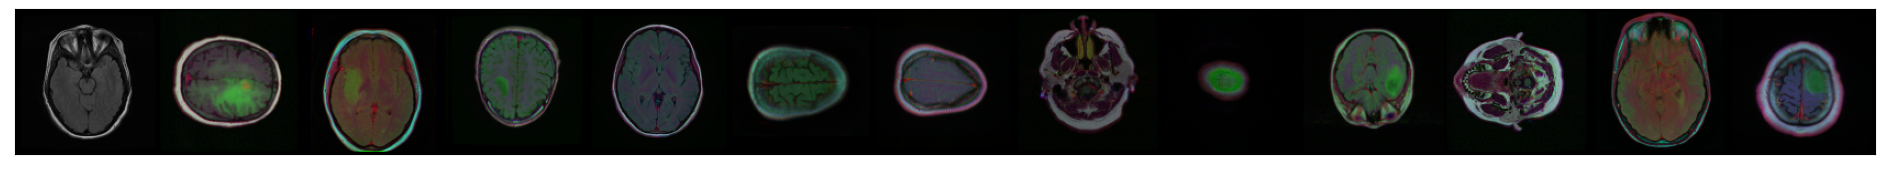

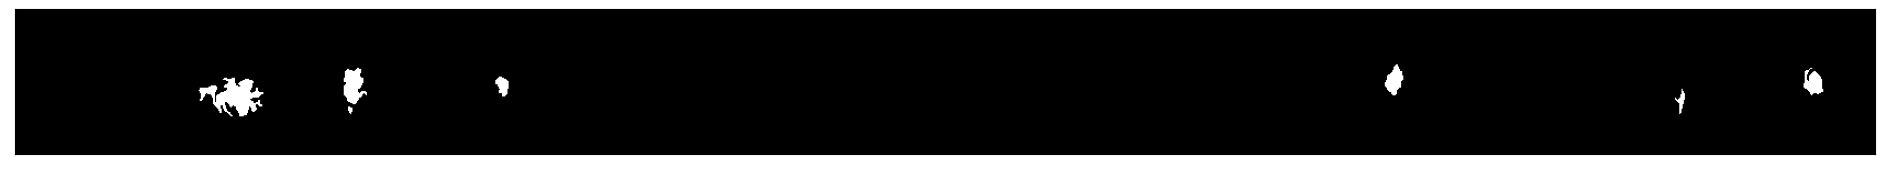

In [12]:
def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_dl)

# Metric & Loss functions

In [13]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

The Dice coefficient measures the similarity between two binary masks and is commonly used in image segmentation tasks.These functions are often used when training deep learning models for image segmentation tasks. During training, the model is optimized to minimize the combined loss (bce_dice_loss), which encourages both accurate pixel-wise predictions and accurate delineation of object boundaries. The dice_coef_metric function can be used to evaluate the model's performance during validation or testing by computing the Dice coefficient between predicted and ground truth masks.

# Training

In [14]:
def train_loop(model, loader, loss_func, optimizer, device):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image, mask = image.to(device), mask.to(device)
        
        optimizer.zero_grad()
        outputs = model(image)
        # Använder sigmoid för att få ut sannolikhet mellan 0 och 1 attention gate.
        outputs = torch.sigmoid(outputs)

        predicted_mask = (outputs >= 0.5).float()  
        
        loss = loss_func(outputs, mask)
        dice = dice_coef_metric(predicted_mask, mask)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_dices.append(dice)
        
        print(f'Batch [{i+1}/{len(loader)}], Loss: {loss.item()}, Dice Coefficient: {dice}')
        
    return train_dices, train_losses


The attention mechanism can produce attention maps or coefficients that are not necessarily bounded between 0 and 1. The values in these maps can be positive or negative, and they represent the importance or relevance of different spatial regions in the input feature maps.

The Dice coefficient is a statistical metric used to quantify the similarity or overlap between two sets or regions. 
A Dice coefficient of 0 indicates no overlap or dissimilarity between the predicted and ground truth masks.
A Dice coefficient of 1 indicates perfect overlap and complete similarity between the predicted and ground truth masks.

In [15]:

def eval_loop(model, loader, loss_func, device, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image, mask = image.to(device), mask.to(device)
    
            outputs = model(image)
            loss = loss_func(outputs, mask)
            
            predicted_mask = (outputs >= 0.5).float()  
            dice = dice_coef_metric(predicted_mask, mask)
            
            val_loss += loss.item()
            val_dice += dice.item()
            
            # Print batch information
            print(f'Validation Batch [{step+1}/{len(loader)}], Loss: {loss.item()}, Dice Coefficient: {dice.item()}')
        
        val_mean_dice = val_dice / (step + 1) 
        val_mean_loss = val_loss / (step + 1)  
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss

In [16]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs, device):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    
    for epoch in range(num_epochs):
        # Training
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer, device)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        
        # Validation
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func, device)
        
        # Record history
        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)
        
        # Adjust learning rate if using a scheduler
        if scheduler is not None:
            scheduler.step(val_mean_dice)
        
        # Print epoch information
        print('Epoch: {}/{} | Train Loss: {:.3f} | Val Loss: {:.3f} | Train DICE: {:.3f} | Val DICE: {:.3f}'.format(
            epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice, val_mean_dice))
    
    return train_loss_history, train_dice_history, val_loss_history, val_dice_history


# UNet Model

In [17]:
# UNET Model
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)
print_model_architecture(model)

torch.Size([1, 1, 128, 128])
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Batch

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 1

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    model, train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs, device)

Training starts
Batch [1/47], Loss: 1.9170100688934326, Dice Coefficient: 0.02032395638525486


KeyboardInterrupt: 

## UNet results

In [33]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('UNET', train_dice_history, val_dice_history, num_epochs)

NameError: name 'train_dice_history' is not defined

A higher Dice coefficient indicates better agreement between the predicted and ground truth masks. In the context of image segmentation, you want the Dice coefficient to increase during training, as this means that the model's predictions are becoming more accurate and aligning better with the ground truth.

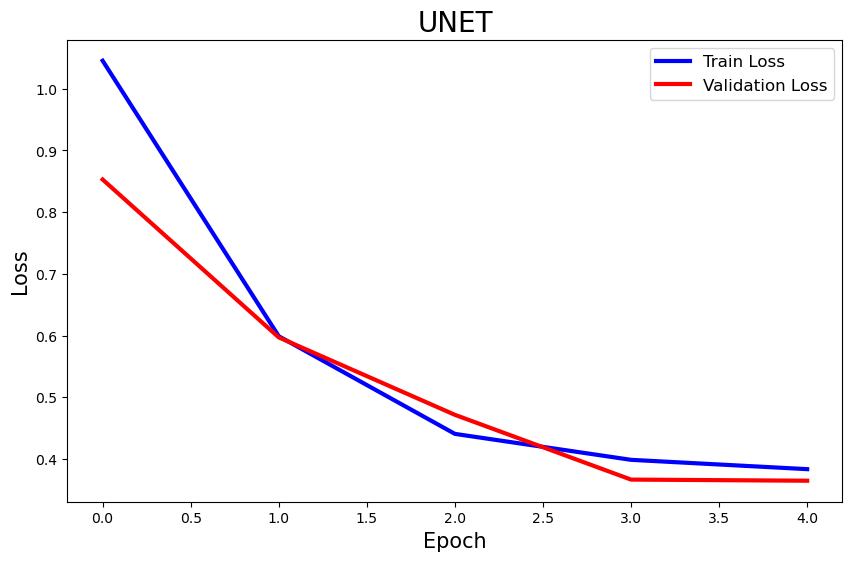

In [29]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()
    
plot_loss_history('UNET', train_loss_history, val_loss_history, num_epochs)

## UNet: Test on testset

In [13]:
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

NameError: name 'eval_loop' is not defined

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Predicted 
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# Plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

# Attention Gate Model

In [18]:
attention_unet = AttentionUNet(n_classes=1).to(device)
output = torch.randn(1,3,256,256).to(device)
print(out.shape)
print_model_architecture(attention_unet)

torch.Size([1, 1, 128, 128])
AttentionUNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [19]:
optimizer = torch.optim.Adam(attention_unet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs  = 3

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    attention_unet, train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs, device)

Training starts


## Attention Gate results

In [23]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('Attention Gate', train_dice_history, val_dice_history, num_epochs)

NameError: name 'train_dice_history' is not defined

In [ ]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()
    
plot_loss_history('Attention gate', train_loss_history, val_loss_history, num_epochs)

## Attention gate test

In [ ]:
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Predicted
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# Plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()